In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import re
from gensim.models import KeyedVectors
import tensorflow as tf
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
f = open("/content/drive/My Drive/Turing/Analise de Sentimento/word2vec/biblia-em-txt.txt", "r")
text = f.read()
f.close()

In [ ]:
def tokenize_sentece(sent):
    tokenized = word_tokenize(sent)
    tokenized = [token.lower() for token in tokenized if token.isalpha()]
    return tokenized

def tokenize_text(text):
    sentences = sent_tokenize(text)
    tokenized_senteces = [tokenize_sentece(sent) for sent in sentences]
    return tokenized_senteces

In [ ]:
sent_tokens = tokenize_text(text)

In [ ]:
word2vec = KeyedVectors.load_word2vec_format("/content/drive/My Drive/Turing/Analise de Sentimento/word2vec/cbow_s600.txt")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
word2vec_embedding = word2vec.get_keras_embedding(train_embeddings=True)
word2vec_vocab_list = list(word2vec.vocab.keys())

In [ ]:
i = 0
vocab = {}

for sent in sent_tokens:
  for token in sent:
    if token in word2vec_vocab_list:
      vocab[token] = i
    else:
      continue
    i+=1

In [ ]:
V = len(vocab)

In [ ]:
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1

In [ ]:
def make_dataset(sent_tokens, vocab, V, C):
    windows_and_target = []
    for sentence in sent_tokens:
        for x, y in get_windows(sentence,C):
            windows_and_target.append((x,y))
        
    return windows_and_target

In [ ]:
dataset = make_dataset(sent_tokens, vocab, V, C=2)

In [ ]:
idx = np.random.randint(low=0,high=len(dataset), size=3)
for i in idx:
    print(dataset[i])

(['senhor', 'deus', 'seus', 'pais'], 'de')
(['joabe', 'filho', 'zeruia', 'e'], 'de')
(['não', 'inundariam', 'a', 'terra'], 'mais')


In [ ]:
def word_to_id(word, vocab):
  if word in vocab:
    return vocab.get(word)
  else:
    return False

In [ ]:
 word_to_id('abra', vocab)

646102

In [ ]:
def word_to_one_hot_vector(word, vocab, V):
    one_hot_vector = np.zeros(V)
    try:
      one_hot_vector[vocab[word]] = 1
    except:
      pass
    return one_hot_vector

In [ ]:
word_to_one_hot_vector('carro', vocab, V).shape

(20939,)

In [ ]:
V

20939

In [ ]:
def mount_train_data_id(raw_batch, vocab, V, epochs=30, batch_size=64):
    for _ in range(epochs):
      features = []
      targets = []

      batch_counter = 0

      raw_batch_len = len(raw_batch)

    
      for datapoint_id, feature_target in enumerate(raw_batch):

        x, y = feature_target 

        if batch_counter == 0:
          features = []
          targets = []

        context = [word_to_id(w, vocab) for w in x]
        central_word = word_to_one_hot_vector(y, vocab, V)

        features.append(context)
        targets.append(central_word)

        batch_counter += 1

        will_yield_batch =  batch_counter == batch_size or datapoint_id == raw_batch_len

        if will_yield_batch:
          batch_counter = 0
          yield np.array(features), np.array(targets)

In [ ]:
df = mount_train_data_id(dataset, vocab, V)

In [ ]:
from keras import backend as K
from keras.layers import Dense
from keras.layers import Average, Lambda
from tensorflow.keras import Input, Model

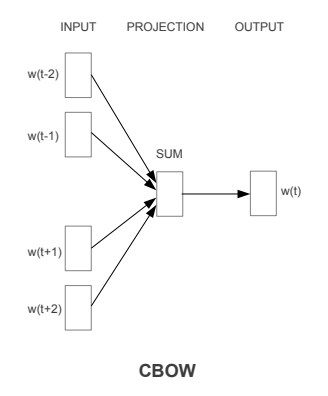

In [ ]:
embeding_dim = 600
vocab_size = V
context_size = 4


input_tensor = Input(shape=(context_size,))

emb_tensor = word2vec_embedding(input_tensor)

average_layer = Lambda(lambda x: K.mean(x, axis=1), output_shape=(embeding_dim,))(emb_tensor)

output_tensor = Dense(vocab_size, activation='softmax')(average_layer)

model = Model(inputs=input_tensor, outputs=output_tensor, name='trainable_word2vec')

In [ ]:
model.summary()

Model: "trainable_word2vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 4, 600)            557763600 
_________________________________________________________________
lambda (Lambda)              (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 20939)             12584339  
Total params: 570,347,939
Trainable params: 570,347,939
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
del(word2vec)

In [ ]:
model.fit(mount_train_data_id(dataset, vocab, V), steps_per_epoch=557, epochs=30)

Epoch 1/30


In [ ]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embeding_dim))

9

In [ ]:
vectors = model.get_weights()[0]
for word, i in vocab.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [ ]:
import gensim

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
word2vec.most_similar('rei')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('imperador', 0.9533310532569885),
 ('príncipe', 0.918188750743866),
 ('ex-rei', 0.8938760161399841),
 ('sultão', 0.8845582604408264),
 ('czar', 0.8801239728927612),
 ('monarca', 0.8758890628814697),
 ('príncipe-herdeiro', 0.8755080103874207),
 ('grão-príncipe', 0.8744364976882935),
 ('faraó', 0.8740960359573364),
 ('patriarca', 0.8731474280357361)]

In [ ]:
w2v.most_similar('rei')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('disse', 0.9999613165855408),
 ('meu', 0.9999608397483826),
 ('quanto', 0.9999606609344482),
 ('assim', 0.999957263469696),
 ('mãos', 0.9999569058418274),
 ('aquele', 0.9999568462371826),
 ('até', 0.9999567270278931),
 ('direito', 0.9999567270278931),
 ('veio', 0.9999555349349976),
 ('alguma', 0.9999555349349976)]